In [1]:
import matplotlib.pyplot as plt
import numpy as np
# import scipy.ndimage
import pandas as pd
from scipy.ndimage import gaussian_filter1d as gsmooth
from scipy.optimize import curve_fit

from tools.file_finder import find_file
import tools.tools as tools

In [6]:
date0 = "210512"
date1 = "210609"

files = [
    find_file("T1", 1, date0, raw=True),
    find_file("T1", 2, date0, raw=True),
    find_file("T1", 3, date0, raw=True),
    find_file("T1", 6, date1, raw=True),
    find_file("T1", 7, date1, raw=True),
]

data_all = [
    pd.read_csv(f, skiprows=20, names=['time', 'counts'], delimiter='\t') for f in files
]

for d in data_all:
    d['smooth'] = gsmooth(d.counts, sigma=5)

titles = [f[-30:] for f in files]

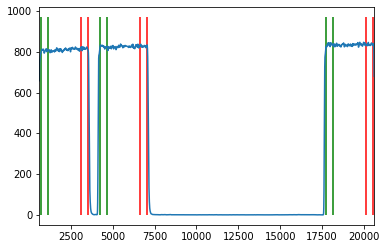

In [17]:
max_counts = np.array([max(data.smooth) for data in data_all])

COUNTS_THRESHOLD = 0.8 # * the max number of counts in any bin

ris_fals = [
    tools.get_rise_falls(np.array(data.smooth), thresh) 
    for data, thresh in zip(data_all, COUNTS_THRESHOLD*max_counts)
]
rises = [rf[0] for rf in ris_fals]
falls = [rf[1] for rf in ris_fals]

rise_ts = [np.array(data.time[r]) for data, r in zip(data_all, rises)]
fall_ts = [np.array(data.time[f]) for data, f in zip(data_all, falls)]

################################################################
integration_width_ns = 400 # ns
# TODO FIx this make it dependent on step size
dt = np.array([spec.time[1] - spec.time[0] for spec in data_all])
integration_width = (integration_width_ns // dt).astype(int)
# integration_width

forwards_shift = 30
backwards_shift = -20
################################################################

def get_readout_start_and_ends(rise_ts, fall_ts):
    """ Assumes that the first rise and fall are always 
    from the same readout pulse. """
    fin_len = min(len(rise_ts), len(fall_ts))
    result = np.zeros((fin_len, 2))
    result[:,0] = rise_ts[:fin_len]
    result[:,1] = fall_ts[:fin_len]
    return result

f = True
start_ends = [] # pairs of pulse start and end times
start_ends_idx = []
for i,(spec, s_rises, s_falls, s_rise_ts, s_fall_ts) in enumerate(zip(
        data_all, rises, falls, rise_ts, fall_ts)):
    start_end = get_readout_start_and_ends(s_rise_ts, s_fall_ts)
    start_end_idx = get_readout_start_and_ends(s_rises, s_falls)
    start_ends.append(start_end)
    start_ends_idx.append(start_end_idx)
if f:
    plt.plot(spec.time, spec.smooth)
    top = max(spec.counts)
    plt.vlines(forwards_shift*dt[i] + s_rise_ts, 0, top, "green")
    plt.vlines(forwards_shift*dt[i] + s_rise_ts + dt[i]*integration_width[i], 0, top, "green")
    plt.vlines(backwards_shift*dt[i] + s_fall_ts, 0, top, "red")
    plt.vlines(backwards_shift*dt[i] + s_fall_ts - dt[i]*integration_width[i], 0, top, "red")
    plt.xlim(s_rise_ts[0], s_fall_ts[2])
    f = False


# readout_counts = np.array(data.counts)[[pulses[:, 0]: pulses[:, 0] + integration_width]] 
take_previous_fall = True # If false, use the fall of the same pulse as the reference signal
spec_tau_axes = []
PL_reads = []
PL_refs = []
for (spec, start_end, start_end_idx, int_width) in zip(
        data_all, start_ends, start_ends_idx, integration_width):
    forward_t = np.arange(int_width)
    x = take_previous_fall * 1 # Scan the arrays in a fashion that depends on this setting
    forward = np.tile(forward_t, (len(start_end_idx)-x, 1)) 
    backward = -forward
    forward += forwards_shift
    backward += backwards_shift
    reads = (forward + start_end_idx[x:, [0]]).astype(int)
    refs = (backward + start_end_idx[:len(start_end_idx)-x, [1]]).astype(int)

    tau = start_end[1:, 0] - start_end[:-1, 1]
    # if not take_previous_fall ignore the first pulse
    reads = reads[1-x:]
    refs  = refs[1-x:]

    arr = np.array(spec.counts)
    reads = np.sum(arr[reads], axis=-1)
    refs  = np.sum(arr[refs], axis=-1)

    spec_tau_axes.append(tau)
    PL_reads.append(reads)
    PL_refs.append(refs)

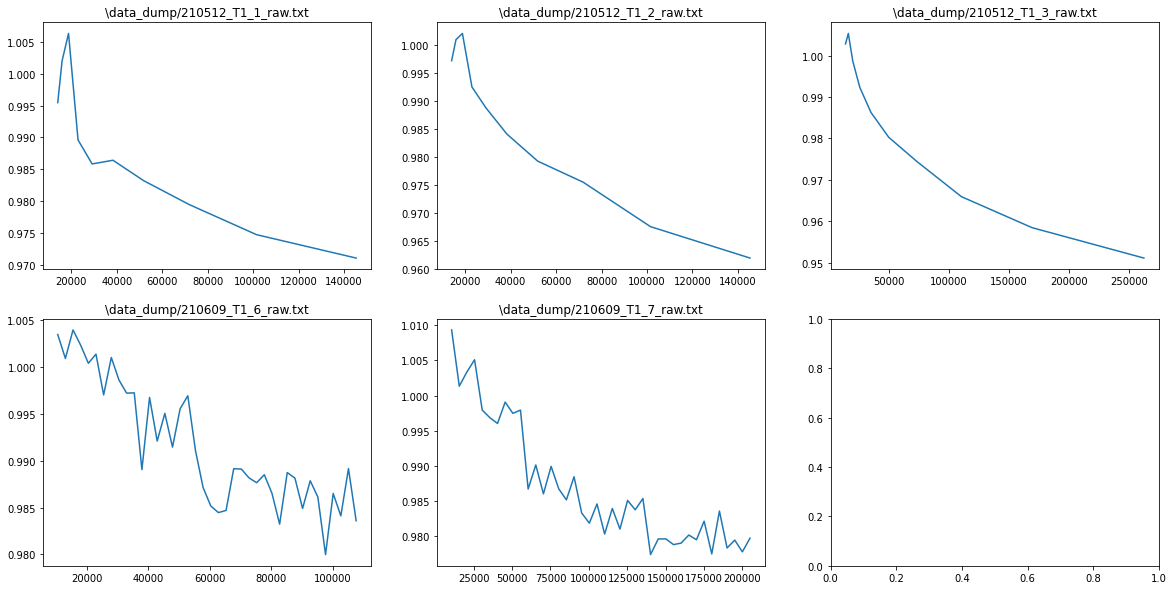

In [16]:
fig = plt.figure(figsize=(20, 10))
n_cols = 3
axes = fig.subplots(
    nrows=(len(titles)+n_cols-1)//n_cols, 
    ncols=n_cols,
    sharex="none").flatten()

for title, tau, reads, refs, ax in zip(titles, spec_tau_axes, PL_reads, PL_refs, axes):
    offset = 1
    tau   = tau[offset::2]
    reads = reads[offset::2]
    refs  = refs[offset::2]
    ax.plot(tau, reads / refs)
    ax.set_title(title)


plt.show()


In [12]:
print(files[-1])


C:\Users\Leo\Documents\TwoDrive\Honours\Data\data_dump/210609_T1_7_raw.txt
